In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import seaborn
import seaborn as sns
import auditory_feature_helpers as aud
import coef_helper_functions as cfh
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm 
Ws = joblib.load('logBSC_H200_W.pkl')
%run time_frequency_features.py
plt.style.use('mb')

/home/mboos/anaconda2/lib/python2.7/site-packages/matplotlib/style/core.py:201: UserWarning: In /home/mboos/.config/matplotlib/stylelib/mb.mplstyle: Bad val "white" on line #20
	"grid.linewidth: white
"
	in file "/home/mboos/.config/matplotlib/stylelib/mb.mplstyle"
	Key grid.linewidth: Could not convert "white" to float
  warnings.warn(message)
/home/mboos/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
auditory_feature_helpers.py:3: DeprecationWarning: Python2 support is deprecated and will be removed in a future release. Consider switching to Python3.
  from nilearn import image as img
/home/mboos/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/base.py:35: RuntimeWarning: numpy.dtype size changed, may indicate binary incom

In [2]:
bscs = joblib.load('../semisupervised/logBSC_H200_stimuli.pkl')
bscs = cfh.reshape_bsc(bscs)
nonlagged_bscs = bscs[:,20:40,:]
connectivity_bsc = np.corrcoef(bscs.mean(axis=1), rowvar=0)
summed_bscs = bscs.sum(axis=1)
speech_overlap = joblib.load('speech_overlap.pkl')
contains_speech = speech_overlap > 5.5
contains_less_speech = speech_overlap < 5.0
corr_speech_BF = np.array([np.corrcoef(summed_bscs[:,i], speech_overlap)[0,1] for i in range(200)])
sensitivity_to_speech = summed_bscs[contains_speech].sum(axis=0) / summed_bscs[contains_less_speech].sum(axis=0)
bscs_per_time = {'100ms': np.corrcoef(np.reshape(bscs, (-1,200)), rowvar=0), '500ms': np.corrcoef(np.reshape(bscs, (12*3539, -1 ,200)).mean(axis=-2), rowvar=0), '200ms': np.corrcoef(np.reshape(bscs, (10*3539, -1 ,200)).mean(axis=-2), rowvar=0),
                 '1000ms': np.corrcoef(np.reshape(bscs, (6*3539, -1 ,200)).mean(axis=-2), rowvar=0), '2000ms': np.corrcoef(np.reshape(bscs, (3*3539, -1 ,200)).mean(axis=-2), rowvar=0),
                '6000ms': np.corrcoef(np.reshape(bscs, (3539, -1 ,200)).mean(axis=-2), rowvar=0)}
bscs_per_time_nonlagged = {'100ms': np.corrcoef(np.reshape(nonlagged_bscs, (-1,200)), rowvar=0), '200ms': np.corrcoef(np.reshape(nonlagged_bscs, (10*3539, -1 ,200)).mean(axis=-2), rowvar=0),
                           '500ms': np.corrcoef(np.reshape(nonlagged_bscs, (4*3539, -1 ,200)).mean(axis=-2), rowvar=0),
                 '1000ms': np.corrcoef(np.reshape(nonlagged_bscs, (2*3539, -1 ,200)).mean(axis=-2), rowvar=0), '2000ms': np.corrcoef(np.reshape(nonlagged_bscs, (3539, -1 ,200)).mean(axis=-2), rowvar=0)}

def distance_from_corrmat(corrmat):
    '''Transforms a correlation matrix into a distance matrix'''
    revcorrmat = -1*corrmat
    distmat = (revcorrmat - revcorrmat.min()) / (revcorrmat.max() - revcorrmat.min())
    return distmat
    
bscs_per_time_distmats = {time: distance_from_corrmat(corrmat) for time, corrmat in bscs_per_time.items()}

In [230]:
from sklearn.metrics import davies_bouldin_score, calinski_harabaz_score
silhouette_time_average_dict = {}
davies_bouldin_dict = {}
calinski_dict = {}
for time in ['100ms', '200ms', '500ms', '1000ms', '2000ms', '6000ms']:
    silhouette_avg_dict = {}
    for clust_i in range(3,100):
        labels = fcluster(Z, t=clust_i, criterion='maxclust')
        silhouette_avg = silhouette_score(bscs_per_time_distmats[time], labels, metric='precomputed', )
        silhouette_avg_dict[clust_i] = silhouette_avg
    silhouette_time_average_dict[time] = silhouette_avg_dict
#    davies_bouldin_dict[clust_i] = davies_bouldin_score(np.reshape(nonlagged_bscs, (10*3539, -1 ,200)).mean(axis=-2).T, labels)
#    calinski_dict[clust_i] = calinski_harabaz_score(np.reshape(nonlagged_bscs, (10*3539, -1 ,200)).mean(axis=-2).T, labels)

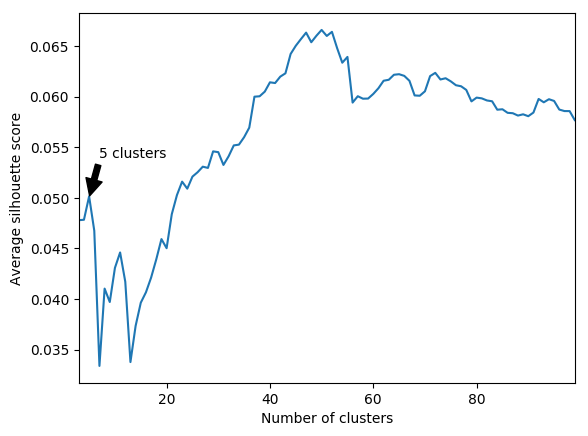

In [318]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(3,100), avg)
plt.xlabel('Number of clusters')
plt.ylabel('Average silhouette score')
plt.xlim(3,99)
ax.annotate('5 clusters', xy=(5, 0.05), xytext=(7, 0.054),
            arrowprops=dict(facecolor='black', shrink=0.05),
            xycoords='data', clip_on=True)
plt.savefig('Average_silhouette_score.svg')

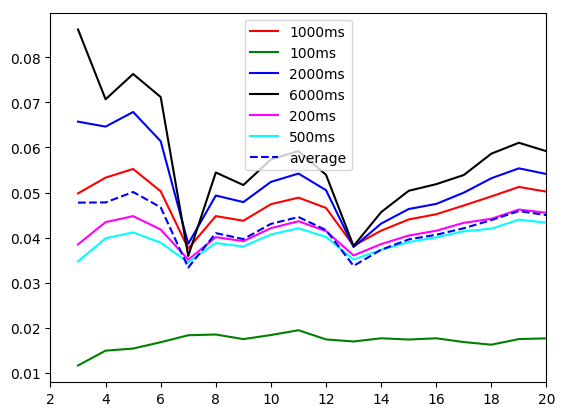

In [256]:
colors = ['r', 'g', 'b', 'k', 'magenta', 'cyan']
for i, (time, sdict) in enumerate(silhouette_time_average_dict.items()):
    plt.plot(*zip(*sdict.items()), label=time, c=colors[i])
plt.plot(silhouette_avg_dict.keys(), np.array([bl.values() for bl in silhouette_time_average_dict.values()]).mean(axis=0), 'b--', label='average')
plt.xlim(2,20)
plt.legend()

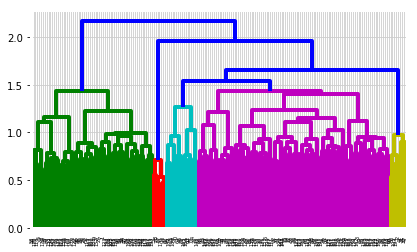

In [3]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
dense_distance = squareform(bscs_per_time_distmats['500ms'], checks=False)
Z = linkage(dense_distance, 'ward', optimal_ordering=True)
fig = plt.figure()
dn = dendrogram(Z)

/home/mboos/anaconda2/lib/python2.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


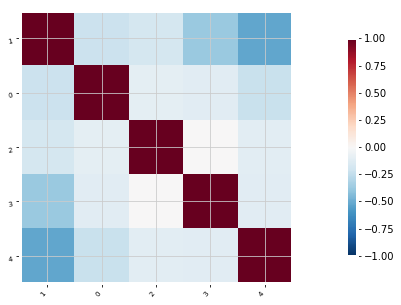

In [18]:
from nilearn.plotting import plot_matrix
plot_matrix(np.corrcoef(cluster_means), labels=np.arange(len(np.unique(labels))), reorder=True, vmin=-1, vmax=1)

In [3]:
cluster_means = joblib.load('cluster_means_really.pkl')
speech_corrs = [np.corrcoef(speech_overlap,cluster_means[i])[0,1] for i in range(5)]

<BarContainer object of 5 artists>

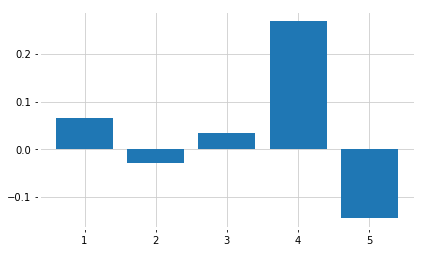

In [4]:
plt.bar(np.arange(5)+1,speech_corrs)
plt.savefig('speech_correlation.svg')